In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
import multiprocessing 
import open3d as o3d


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
cam0=np.array([[5299.313, 0, 1263.818], [0 ,5299.313 ,977.763], [0 ,0 ,1]])
cam1=np.array([[5299.313 ,0 ,1438.004], [0, 5299.313, 977.763],[ 0 ,0 ,1]])
b=177.288

In [3]:
current_dir = os.getcwd()
image_path = os.path.join(current_dir, "bikeL.png")
left_image = cv2.imread(image_path,0)
right_image = os.path.join(current_dir, "bikeR.png")
right_image = cv2.imread(right_image,0)


In [11]:

def compute_SAD_loss(left_img, right_img, x_, x, y, kernel_half):
    height, width = left_img.shape[:2]
    sad_loss = 0
    for v in range(-kernel_half, kernel_half):
        for u in range(-kernel_half, kernel_half):
            left_pixel = left_img[max(0, min(height - 1, y + v))][max(0, min(width - 1, x + u))]
            right_pixel = right_img[max(0, min(height - 1, y + v))][max(0, min(width - 1, x_ + u))]
            sad_loss += abs(int(left_pixel) - int(right_pixel))
    return sad_loss
  

def compare_and_get_loss(left_img,right_img,x,y,block_size,search_range):

    sad_loss = sys.maxsize
    min_x_ = None
    kernel_half = block_size//2
    for x_ in range(max(0, x - search_range), min(right_img.shape[1] - block_size, x + search_range + 1)):
        
        current_sad_loss = compute_SAD_loss(left_img,right_img,x_,x,y,kernel_half)
        if current_sad_loss< sad_loss:
            sad_loss = current_sad_loss
            min_x_ = x_
    
    return min_x_
def compute_object_coordinates(disp_left, cam0, b):
    height, width = disp_left.shape
    object_coord = np.zeros((height, width, 3))

    for j in range(height):
        for i in range(width):
            depth = b * cam0[0, 0] / (disp_left[j, i]+0.001)
            X = (i - cam0[0, 2]) * depth / cam0[0, 0]
            Y = (j - cam0[1, 2]) * depth / cam0[1, 1]
            Z = depth
            object_coord[j, i, :] = [X, Y, Z]

    return object_coord

def compute_disparity_map(left_img, right_img, block_size=6,search_range=50):
    height, width = left_img.shape[0], left_img.shape[1]
    
    pad_height = block_size // 2
    pad_width = block_size // 2
    
    diff_array = np.zeros((height, width), dtype=np.float32)
    
    for j in tqdm(range(pad_height,height-pad_height)):
        for i in range(pad_width,width-pad_width):
            x_ = compare_and_get_loss(left_img, right_img, i, j,block_size,search_range)
            diff_array[j,i] = (x_ - i)
            

    max_diff = np.max(diff_array)
    min_diff = np.min(diff_array)
    normalized_diff = (diff_array - min_diff) * (255 / max_diff - min_diff)
    disparity_map = normalized_diff.astype(np.uint8)
    
    return disparity_map

In [7]:

desired_width = 1024
desired_height = 768

resized_left_image = cv2.resize(left_image, (desired_width, desired_height))
resized_right_image = cv2.resize(right_image, (desired_width, desired_height))

dispaity_map = compute_disparity_map(resized_left_image,resized_right_image,block_size=7)

(768, 1024)


100%|██████████| 762/762 [1:55:22<00:00,  9.08s/it]    


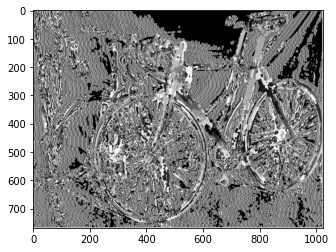

In [41]:
plt.imshow(dispaity_map, cmap='gray')

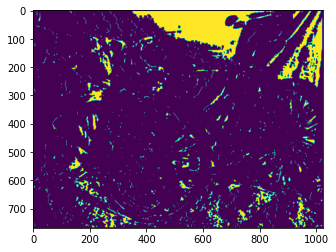

In [43]:
disp_left = dispaity_map.astype(np.float32)/16
depth_map =np.ones(disp_left.shape)
depth_map = b*cam0[0][0]/(disp_left+0.001)
plt.imshow(depth_map)

In [ ]:

disparity_map = disp_left
object_coord = compute_object_coordinates(disparity_map, cam0, b)
object_coord_rescaled = cv2.resize(object_coord, (desired_width, desired_height))

intensity_values = resized_left_image

intensity_values_normalized = (intensity_values - intensity_values.min()) / (intensity_values.max() - intensity_values.min())

points = object_coord_rescaled.reshape(-1, 3)
colors = intensity_values_normalized.reshape(-1, 1)



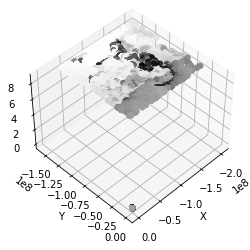

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0].flatten(), points[:,1].flatten(), points[:,2].flatten(), c=colors.flatten(), cmap='gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
elevation_angle = 45 
azimuth_angle = 45    
ax.view_init(elev=elevation_angle, azim=azimuth_angle)
plt.show()